<a href="https://colab.research.google.com/github/jonatapaulino/Reconhecimento-Facial-com-CNN/blob/main/Classifica%C3%A7%C3%A3o_de_emo%C3%A7%C3%B5es_com_CNN7_LittleVGG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classificação de emoções

## Importação das bibliotecas

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab.patches import cv2_imshow
import zipfile
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization

## Carregamento das imagens

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Descompactação arquivos zip
path = '/content/drive/MyDrive/experimento_image/fer_images.zip'
zip_object = zipfile.ZipFile(file=path, mode='r')
#zip_object.extractall('./')
zip_object.extractall('/content/drive/MyDrive/experimento_image')
zip_object.close()

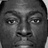

In [ ]:
tf.keras.preprocessing.image.load_img('/content/drive/MyDrive/experimento_image/fer2013/train/Neutral/10.jpg')

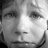

In [ ]:
imagem = tf.keras.preprocessing.image.load_img('/content/drive/MyDrive/experimento_image/fer2013/train/Sad/1.jpg')
imagem

### Bases de treinamento e teste

In [ ]:
gerador_treinamento = ImageDataGenerator(rescale=1./255,
                                        rotation_range=7,
                                        horizontal_flip=True,
                                        zoom_range=0.2)

dataset_treinamento = gerador_treinamento.flow_from_directory('/content/drive/MyDrive/experimento_image/fer2013/train',
                                                        target_size = (48, 48),
                                                        batch_size = 16,
                                                        class_mode = 'categorical',
                                                        shuffle = True)

Found 28709 images belonging to 7 classes.


In [ ]:
# Visualizando Classes 
dataset_treinamento.classes

array([0, 0, 0, ..., 6, 6, 6], dtype=int32)

In [ ]:
# Visualizando valore únicos das classes
np.unique(dataset_treinamento.classes, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6], dtype=int32),
 array([3995,  436, 4097, 7215, 4965, 4830, 3171]))

In [ ]:
# Observando o nome das classes
dataset_treinamento.class_indices

{'Angry': 0,
 'Disgust': 1,
 'Fear': 2,
 'Happy': 3,
 'Neutral': 4,
 'Sad': 5,
 'Surprise': 6}

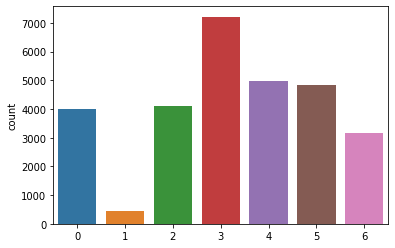

In [ ]:
# Plotando a visualização das classes
sns.countplot(x = dataset_treinamento.classes);

In [ ]:
gerador_teste = ImageDataGenerator(rescale=1./255)

dataset_teste = gerador_teste.flow_from_directory('/content/drive/MyDrive/experimento_image/fer2013/validation',
                                                  target_size = (48, 48),
                                                  batch_size = 1,
                                                  class_mode = 'categorical',
                                                  shuffle = False)

Found 3589 images belonging to 7 classes.


## Construção e treinamento da rede neural

In [ ]:
# Número de filtros
num_detectors = 32
# Numero e classes
num_classes = 7
# Tamanho da imagem
width, height = 48, 48
# Numero de epocas
epochs = 70

# Implementando a estrutura da rede
network = Sequential()

network.add(Conv2D(num_detectors, (3, 3), activation = 'relu', padding = 'same', input_shape = (width, height, 3)))
network.add(BatchNormalization())
network.add(Conv2D(num_detectors, (3, 3), activation = 'relu', padding = "same"))
network.add(BatchNormalization())
network.add(MaxPooling2D(pool_size=(2, 2)))
network.add(Dropout(0.2))

network.add(Conv2D(2*num_detectors, (3, 3), activation = 'relu', padding="same"))
network.add(BatchNormalization())
network.add(Conv2D(2*num_detectors, (3, 3), activation = 'relu', padding="same"))
network.add(BatchNormalization())
network.add(MaxPooling2D(pool_size=(2, 2)))
network.add(Dropout(0.2))

network.add(Conv2D(2*2*num_detectors, (3, 3), activation = 'relu', padding="same"))
network.add(BatchNormalization())
network.add(Conv2D(2*2*num_detectors, (3, 3), activation = 'relu', padding="same"))
network.add(BatchNormalization())
network.add(MaxPooling2D(pool_size=(2, 2)))
network.add(Dropout(0.2))

network.add(Conv2D(2*2*2*num_detectors, (3, 3), activation = 'relu', padding="same"))
network.add(BatchNormalization())
network.add(Conv2D(2*2*2*num_detectors, (3, 3), activation = 'relu', padding="same"))
network.add(BatchNormalization())
network.add(MaxPooling2D(pool_size=(2, 2)))
network.add(Dropout(0.2))

network.add(Flatten())

# Primeira Camada escondida com 64 neurônios
network.add(Dense(2*num_detectors, activation = 'relu'))
network.add(BatchNormalization())
network.add(Dropout(0.2))

# Segunda camada escondida com 64 neurônios
network.add(Dense(2*num_detectors, activation = 'relu'))
network.add(BatchNormalization())
network.add(Dropout(0.2))

# Camada de saídas que são 7 classes
network.add(Dense(units=num_classes, activation='softmax'))

# Observar a estrutura da rede.
print(network.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                        

In [ ]:
network.compile(optimizer = 'Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
network.fit(dataset_treinamento, epochs=epochs)

Epoch 1/70
1795/1795 [==============================] - 6026s 3s/step - loss: 1.8838 - accuracy: 0.2505
Epoch 2/70
1795/1795 [==============================] - 75s 42ms/step - loss: 1.5991 - accuracy: 0.3678
Epoch 3/70
1795/1795 [==============================] - 74s 41ms/step - loss: 1.4236 - accuracy: 0.4520
Epoch 4/70
1795/1795 [==============================] - 74s 41ms/step - loss: 1.3308 - accuracy: 0.4903
Epoch 5/70
1795/1795 [==============================] - 74s 41ms/step - loss: 1.2610 - accuracy: 0.5238
Epoch 6/70
1795/1795 [==============================] - 74s 41ms/step - loss: 1.2179 - accuracy: 0.5441
Epoch 7/70
1795/1795 [==============================] - 74s 41ms/step - loss: 1.1820 - accuracy: 0.5582
Epoch 8/70
1795/1795 [==============================] - 74s 41ms/step - loss: 1.1543 - accuracy: 0.5692
Epoch 9/70
1795/1795 [==============================] - 76s 42ms/step - loss: 1.1410 - accuracy: 0.5751
Epoch 10/70
1795/1795 [==============================] - 74s 41m

## Salvando e Carregando a Rede Neural

In [ ]:
#Salvando arquivo json
model_json = network.to_json()
with open('/content/drive/MyDrive/experimento_image/WeigthtsProb/network_emotions_prob.json', 'w') as json_file:
    json_file.write(model_json)

In [ ]:
#Salvando pesos
from keras.models import save_model
network_saved = save_model(network,'/content/drive/MyDrive/experimento_image/WeigthtsProb/weights_emotions_prob.haf5')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/experimento_image/WeigthtsProb/weights_emotions_prob.haf5/assets


In [ ]:
# Abertura dos pesos salvos com sua estrutura
with open('/content/drive/MyDrive/experimento_image/WeigthtsProb/network_emotions_prob.json') as json_file:
    json_saved_model = json_file.read()
json_saved_model

'{"class_name": "Sequential", "config": {"name": "sequential", "layers": [{"class_name": "InputLayer", "config": {"batch_input_shape": [null, 48, 48, 3], "dtype": "float32", "sparse": false, "ragged": false, "name": "conv2d_input"}}, {"class_name": "Conv2D", "config": {"name": "conv2d", "trainable": true, "batch_input_shape": [null, 48, 48, 3], "dtype": "float32", "filters": 32, "kernel_size": [3, 3], "strides": [1, 1], "padding": "same", "data_format": "channels_last", "dilation_rate": [1, 1], "groups": 1, "activation": "relu", "use_bias": true, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}}, {"class_name": "BatchNormalization", "config": {"name": "batch_normalization", "trainable": true, "dtype": "float32", "axis": [3], "momentum": 0.99, "epsilon": 0.001, "c

In [ ]:
network_loaded = tf.keras.models.model_from_json(json_saved_model)

network_loaded.load_weights('/content/drive/MyDrive/experimento_image/WeigthtsProb/weights_emotions_prob.haf5')

network_loaded.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])

In [ ]:
network_loaded.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                        

## Avaliação da rede neural

In [ ]:
network.evaluate(dataset_teste)

3589/3589 [==============================] - 850s 237ms/step - loss: 1.5339 - accuracy: 0.5776


[1.533948302268982, 0.5775982141494751]

In [ ]:
previsoes = network.predict(dataset_teste)
previsoes

array([[8.80189180e-01, 4.79936739e-03, 1.65960994e-02, ...,
        1.84035711e-02, 7.76868165e-02, 4.11859597e-04],
       [9.28587854e-01, 1.52171429e-04, 7.01520219e-02, ...,
        9.25150089e-05, 7.23596080e-04, 2.91183736e-04],
       [8.93965364e-01, 1.00177049e-03, 4.41989452e-02, ...,
        4.48338361e-03, 5.37649691e-02, 3.89822089e-04],
       ...,
       [8.83672968e-04, 5.22522396e-06, 4.90738451e-02, ...,
        1.96099468e-03, 1.37095083e-03, 9.46701586e-01],
       [1.90852117e-02, 2.99411127e-04, 5.85621260e-02, ...,
        3.55007440e-01, 1.59230884e-02, 5.45642018e-01],
       [1.05145268e-01, 2.10538949e-03, 7.58871809e-02, ...,
        1.09722558e-02, 1.29026165e-02, 7.92931080e-01]], dtype=float32)

In [ ]:
# Previsão para o modelo
previsoes = np.argmax(previsoes, axis = 1)
previsoes

array([0, 0, 0, ..., 6, 6, 6])

In [ ]:
# Base de dados
dataset_teste.classes

array([0, 0, 0, ..., 6, 6, 6], dtype=int32)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(dataset_teste.classes, previsoes)

0.5775982167734746

In [ ]:
dataset_teste.class_indices

{'Angry': 0,
 'Disgust': 1,
 'Fear': 2,
 'Happy': 3,
 'Neutral': 4,
 'Sad': 5,
 'Surprise': 6}

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(dataset_teste.classes, previsoes)
cm

array([[299,   9,  57,  13,  54,  55,   4],
       [ 10,  39,   2,   1,   1,   1,   1],
       [ 58,   2, 252,  12,  71,  87,  46],
       [ 15,   2,  20, 766,  38,  23,  15],
       [ 91,  11,  96, 156, 116,  98,  58],
       [ 54,   4,  78,  29, 141, 279,   9],
       [ 13,   0,  49,  14,  11,   7, 322]])

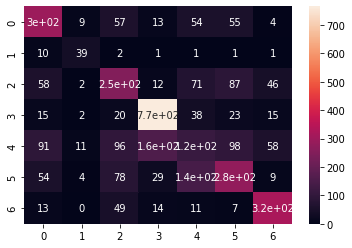

In [ ]:
sns.heatmap(cm, annot=True);

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(dataset_teste.classes, previsoes))

              precision    recall  f1-score   support

           0       0.55      0.61      0.58       491
           1       0.58      0.71      0.64        55
           2       0.45      0.48      0.47       528
           3       0.77      0.87      0.82       879
           4       0.27      0.19      0.22       626
           5       0.51      0.47      0.49       594
           6       0.71      0.77      0.74       416

    accuracy                           0.58      3589
   macro avg       0.55      0.59      0.56      3589
weighted avg       0.55      0.58      0.56      3589



## Classificação de uma única imagem

In [ ]:
# Carregando a imagem
imagem = cv2.imread('/content/drive/MyDrive/experimento imagens/gabriel.png')
cv2_imshow(imagem)

In [ ]:
imagem.shape

In [ ]:
# Capturar somente a parte da face
detector_face = cv2.CascadeClassifier('/content/drive/MyDrive/experimento_image/haarcascade_frontalface_default.xml')

In [ ]:
imagem_original = imagem.copy()
deteccoes = detector_face.detectMultiScale(imagem_original)

In [ ]:
# Indentificação do local da face -> x, y, tamanho da face
deteccoes

In [ ]:
# Extraindo parte necessária -> posição inicial e posição final
roi = imagem[40:40 + 128, 162:162 + 128]
cv2_imshow(roi)

In [ ]:
roi.shape

In [ ]:
# Redimensionando a imagem
roi = cv2.resize(roi, (48, 48))
cv2_imshow(roi)

In [ ]:
roi.shape

In [ ]:
roi

In [ ]:
# Aplicar normalização de escala
roi = roi / 255
roi

In [ ]:
roi.shape

(48, 48, 3)

In [ ]:
# Criação do bath -> quantidade de imagens enviadas a rede = 1
import numpy as np
roi = np.expand_dims(roi, axis = 0)
roi.shape

(1, 1, 128, 128, 3)

In [ ]:
# Gerando probabilidades
probs = network_loaded.predict(roi)
probs

array([[0.01952875, 0.01462624, 0.23866977, 0.01075243, 0.5762978 ,
        0.04924279, 0.0908822 ]], dtype=float32)

In [ ]:
# Indice onde há o maior valor
previsao = np.argmax(probs)
previsao

In [ ]:
# Avaliação final
dataset_teste.class_indices

## Classificação de multiplas imagens

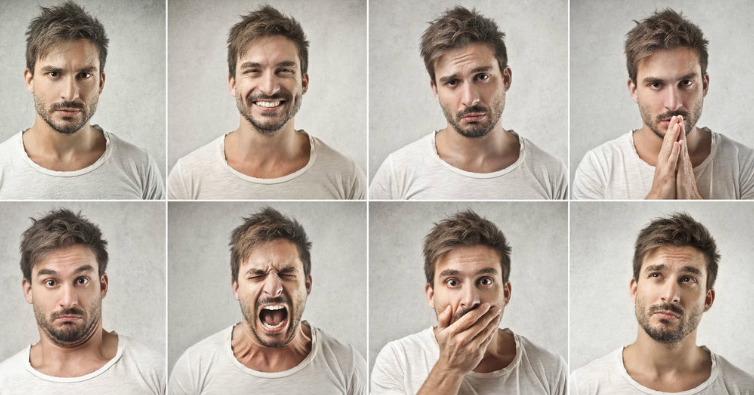

In [ ]:
imagem = cv2.imread('/content/drive/MyDrive/experimento_image/Images/faces_emotions.png')
cv2_imshow(imagem)

In [ ]:
# Capturar somente a parte da face
detector_face = cv2.CascadeClassifier('/content/drive/MyDrive/experimento_image/haarcascade_frontalface_default.xml')

In [ ]:
deteccoes = detector_face.detectMultiScale(imagem)
deteccoes

array([[224,  35,  90,  90],
       [625,  49,  91,  91],
       [ 23,  41,  92,  92],
       [420,  43,  97,  97],
       [420, 242,  97,  97],
       [ 18, 243,  98,  98],
       [229, 242,  85,  85],
       [627, 241,  91,  91]], dtype=int32)

In [ ]:
dataset_teste.class_indices

{'Angry': 0,
 'Disgust': 1,
 'Fear': 2,
 'Happy': 3,
 'Neutral': 4,
 'Sad': 5,
 'Surprise': 6}

In [ ]:
dataset_teste.class_indices.keys()

dict_keys(['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise'])

In [ ]:
emotions = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

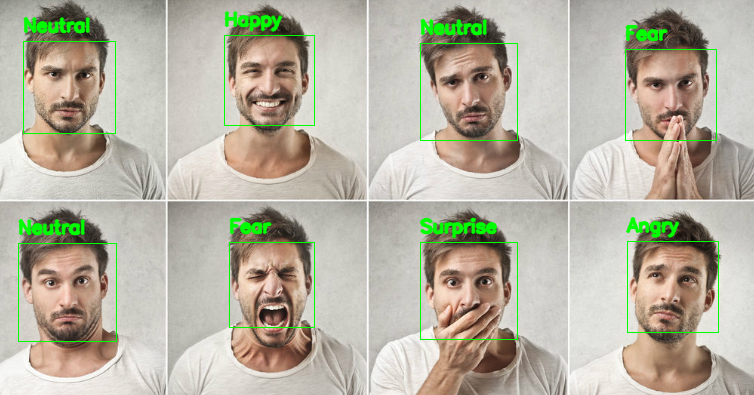

In [ ]:
# Valores dos boxs
for (x, y, w, h) in deteccoes:
    #print(x, y, w, h)
    ## Extraindo o roi, região de interesse
    cv2.rectangle(imagem, (x, y), (x + w, y + h), (0, 255, 0), 1)
    roi = imagem[y:y + h, x:x + w]
    #cv2_imshow(roi)
    roi = cv2.resize(roi, (48, 48))
    #cv2_imshow(roi)
    ## Normalização
    roi = roi / 255
    roi = np.expand_dims(roi, axis = 0)
    #print(roi.shape)
    previsao = network_loaded.predict(roi)
    #print(previsao)
    ## Adicionar o texto na imagem - argmax retorna o índice - por meio do índice acessamos a emoção
    cv2.putText(imagem, emotions[np.argmax(previsao)], (x, y -10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2, cv2.LINE_AA)
cv2_imshow(imagem)

## Base CK

In [ ]:
gerador_teste = ImageDataGenerator(rescale=1./255)

dataset_teste = gerador_teste.flow_from_directory('/content/drive/MyDrive/experimento_image/ck/validation',
                                                  target_size = (48, 48),
                                                  batch_size = 1,
                                                  class_mode = 'categorical',
                                                  shuffle = False)

Found 268 images belonging to 7 classes.


In [ ]:
previsoes = network.predict(dataset_teste)
previsoes

array([[0.14169206, 0.14226371, 0.14297618, ..., 0.14198501, 0.14394881,
        0.14401974],
       [0.14153491, 0.14222522, 0.14305224, ..., 0.14190114, 0.14387827,
        0.14416857],
       [0.14159839, 0.14236204, 0.1429106 , ..., 0.14190795, 0.14392668,
        0.14414953],
       ...,
       [0.14138164, 0.1422118 , 0.14308082, ..., 0.14201434, 0.14398563,
        0.14415306],
       [0.14151475, 0.14237922, 0.14301807, ..., 0.1417056 , 0.14405979,
        0.1442647 ],
       [0.14151186, 0.14211252, 0.14308013, ..., 0.14228024, 0.14392632,
        0.14436205]], dtype=float32)

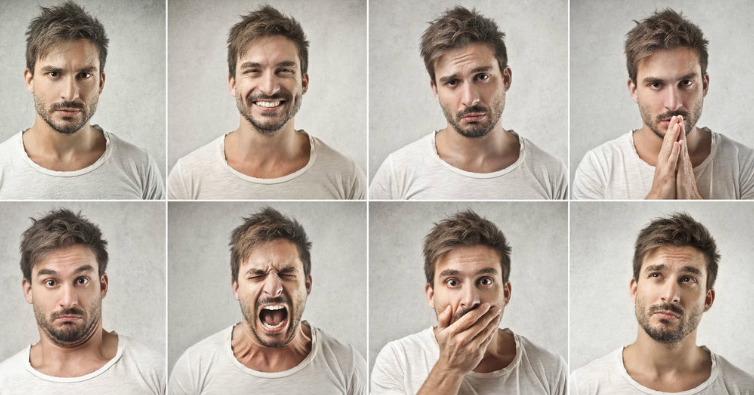

In [ ]:
imagem = cv2.imread('/content/drive/MyDrive/experimento_image/Images/faces_emotions.png')
cv2_imshow(imagem)

In [ ]:
deteccoes = detector_face.detectMultiScale(imagem)
deteccoes

array([[224,  35,  90,  90],
       [625,  49,  91,  91],
       [ 23,  41,  92,  92],
       [420,  43,  97,  97],
       [420, 242,  97,  97],
       [ 18, 243,  98,  98],
       [229, 242,  85,  85],
       [627, 241,  91,  91]], dtype=int32)

In [ ]:
dataset_teste.class_indices

{'Angry': 0,
 'Disgust': 1,
 'Fear': 2,
 'Happy': 3,
 'Neitral': 4,
 'Sad': 5,
 'Surprise': 6}

In [ ]:
dataset_teste.class_indices.keys()

dict_keys(['Angry', 'Disgust', 'Fear', 'Happy', 'Neitral', 'Sad', 'Surprise'])

In [ ]:
emotions = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

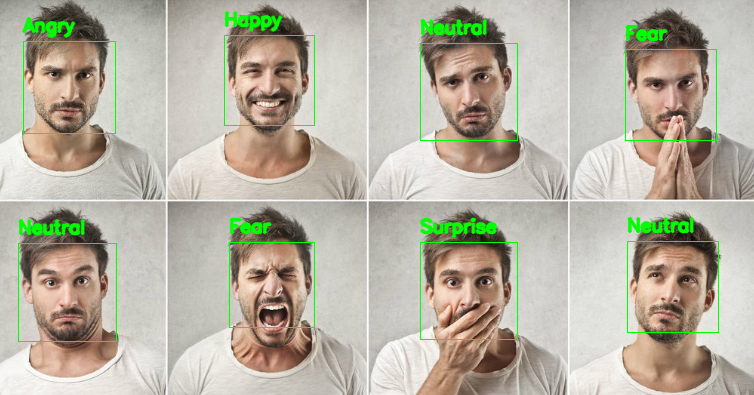

In [ ]:
# Valores dos boxs
for (x, y, w, h) in deteccoes:
    #print(x, y, w, h)
    ## Extraindo o roi, região de interesse
    cv2.rectangle(imagem, (x, y), (x + w, y + h), (0, 255, 0), 1)
    roi = imagem[y:y + h, x:x + w]
    #cv2_imshow(roi)
    roi = cv2.resize(roi, (48, 48))
    #cv2_imshow(roi)
    ## Normalização
    roi = roi / 255
    roi = np.expand_dims(roi, axis = 0)
    #print(roi.shape)
    previsao = network_loaded.predict(roi)
    #print(previsao)
    ## Adicionar o texto na imagem - argmax retorna o índice - por meio do índice acessamos a emoção
    cv2.putText(imagem, emotions[np.argmax(previsao)], (x, y -10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2, cv2.LINE_AA)
cv2_imshow(imagem)